In [5]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
import numpy as np
import xgboost as xgb
# # Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class compare_linear_xgboost:
    def __init__(self):
        self.ratio = np.linspace(0.1,10,20)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = \
           train_validation_test_split(
               X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)
        self.dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        self.param = {}
        # use softmax multi-class classification
        self.param['objective'] = 'binary:logistic'
        # param['eta'] = 0.1
        self.param['max_depth'] = 25
        self.param['silent'] = 1
        self.param['nthread'] = 4
        self.param['num_class'] = 1
        # param['lambda'] = 1
        # param['alpha'] = 1
        self.num_round = 50
        self.test = xgb.DMatrix(self.X_test)
        
    def plot_linear(self,r):
        class_weight = {0: 1, 1: r}
        model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
        model.fit(self.X_train, self.y_train)
        plt.figure(figsize=(10, 6))
        plt.title(f"ratio {r}")
        plot_decision_regions(self.X_val, self.y_val, model, legend=0);

    def plot_xgboost(self,r):
        self.dtrain.set_weight([1 if i == 0 else r for i in self.y_train])
        bst = xgb.train(self.param, self.dtrain, self.num_round)
        # # make prediction
        pred = bst.predict(self.test)
        y_pred = [1 if round(p) == 1 else 0 for p in pred]
        g = []
        o = []
        gp = []
        op = []
        for i in range(self.X_test.shape[0]):
            if self.y_test[i] == 1 and y_pred[i] == 1:
                g.append([self.X_test[i][0], self.X_test[i][1],y_pred[i]])
            elif self.y_test[i] == 0 and y_pred[i] == 1:
                gp.append([self.X_test[i][0], self.X_test[i][1],y_pred[i]])
            elif self.y_test[i] == 1 and y_pred[i] == 0:
                op.append([self.X_test[i][0], self.X_test[i][1],y_pred[i]])
            else: #y_val[i] == 0 and y_pred[i] == 0:
                o.append([self.X_test[i][0], self.X_test[i][1],y_pred[i]])
        g = np.array(g)
        o = np.array(o)
        gp = np.array(gp)
        op = np.array(op)
        
        plt.figure(figsize=(10, 6))
        if g.shape[0] > 0:
            plt.scatter(g[:,0],g[:,1], color='orange', marker='^')
        if o.shape[0] > 0:
            plt.scatter(o[:,0],o[:,1], color='b', marker='s')  
        if gp.shape[0] > 0:
            plt.scatter(gp[:,0],gp[:,1], color='r', marker='^')
        if op.shape[0] > 0:
            plt.scatter(op[:,0],op[:,1], color='g', marker='s')
        plt.title(f"ratio {r}")
        plt.show()
            
    def run(self):
        for f in self.ratio:
             self.plot_linear(f)
             self.plot_xgboost(f)
    
        

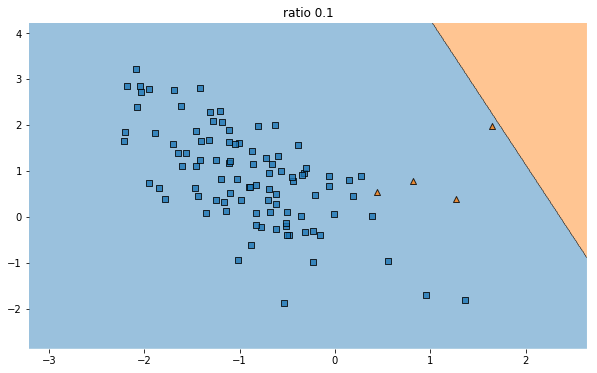

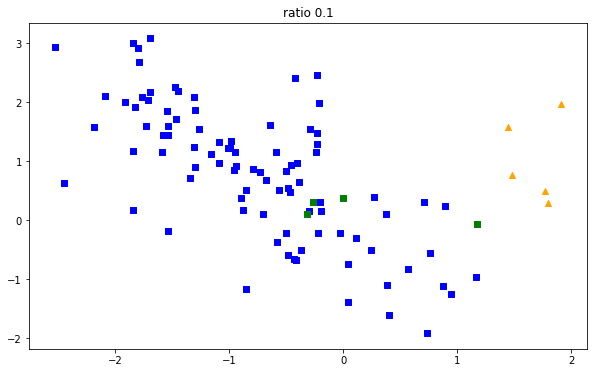

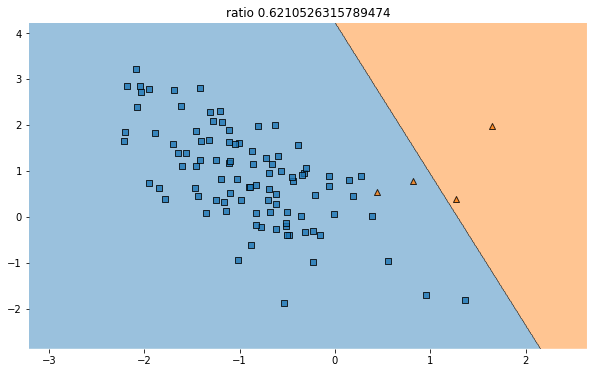

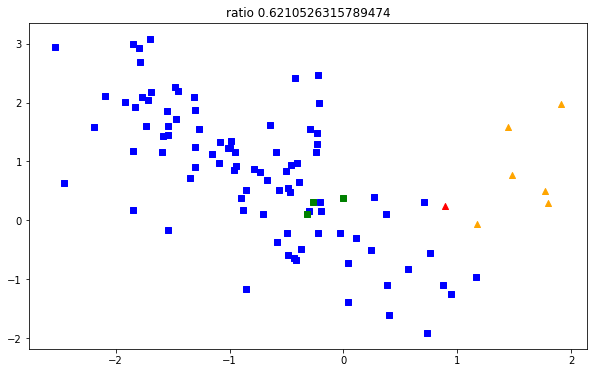

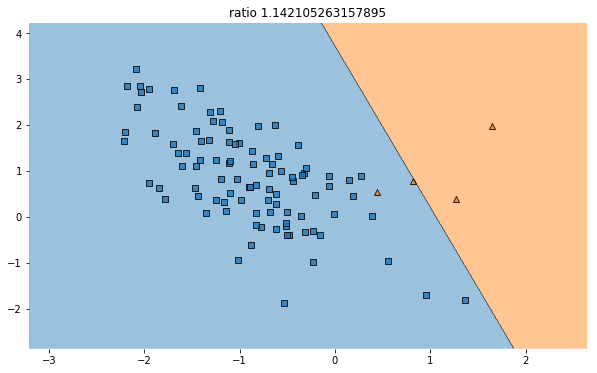

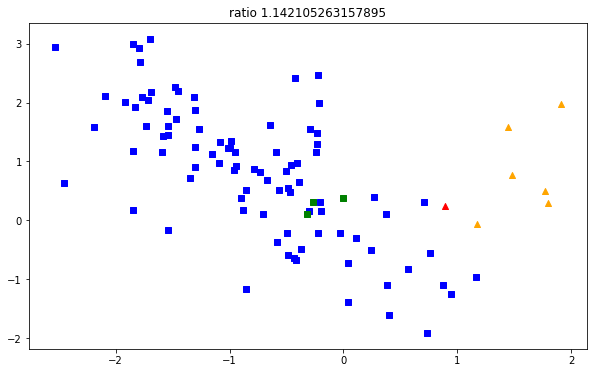

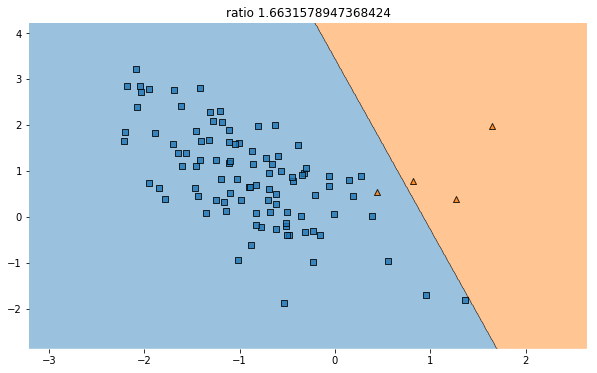

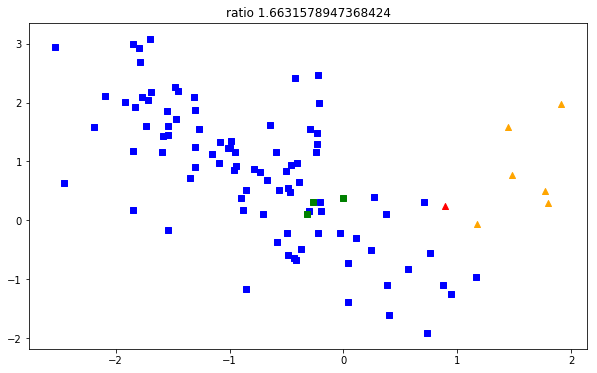

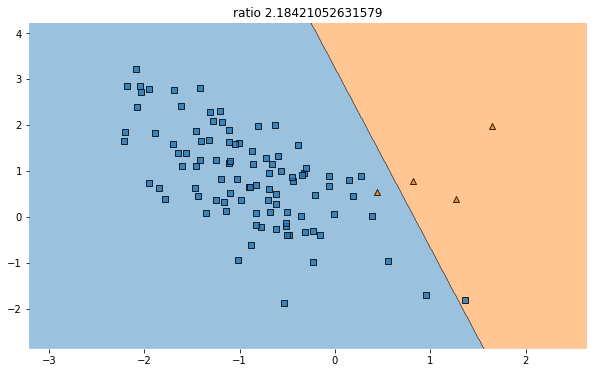

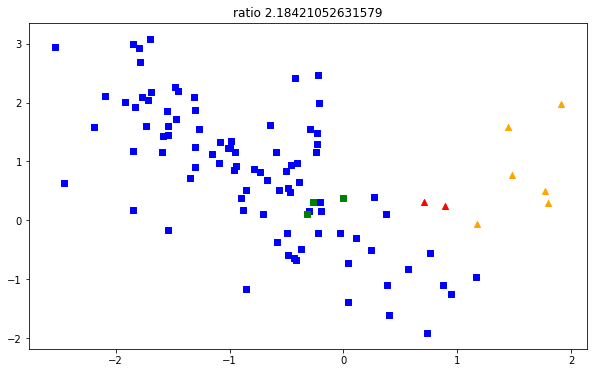

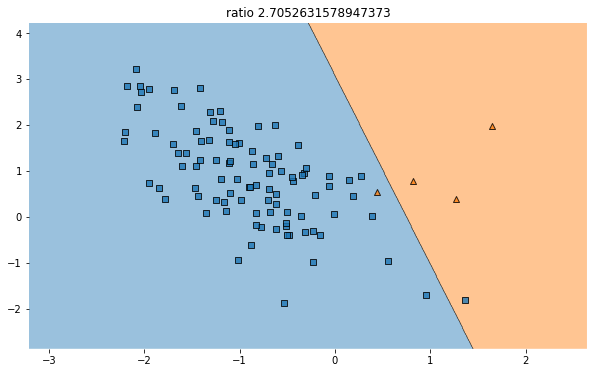

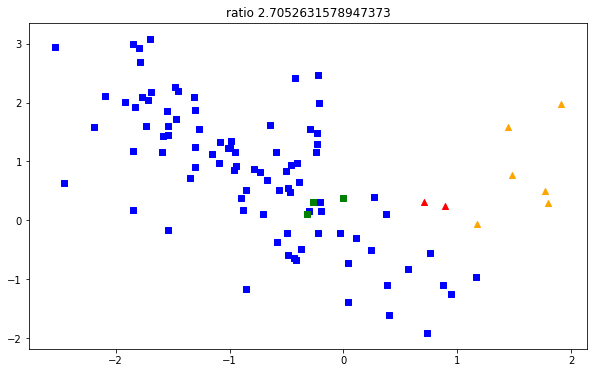

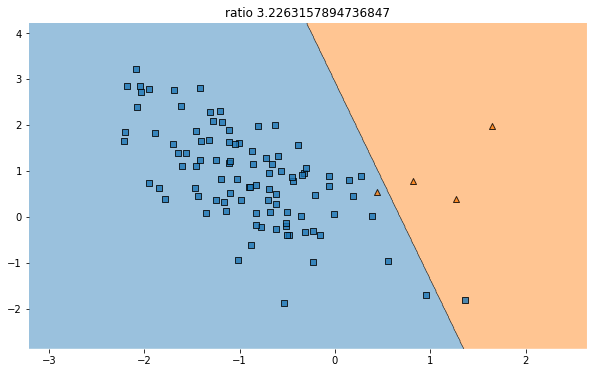

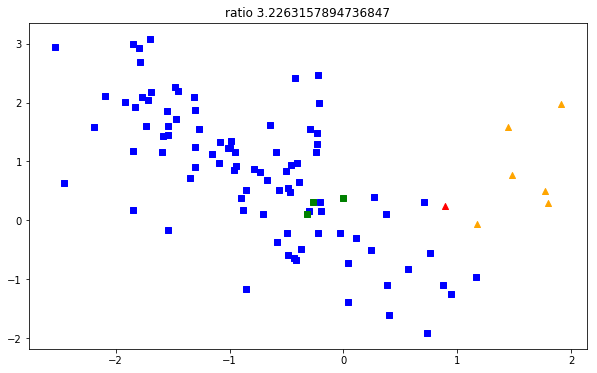

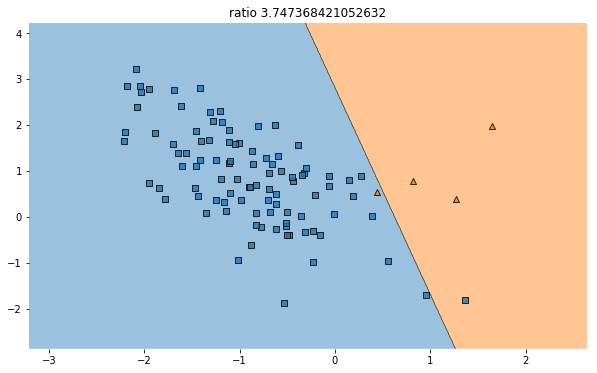

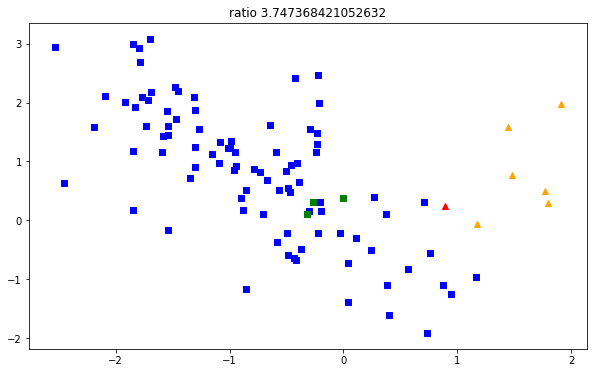

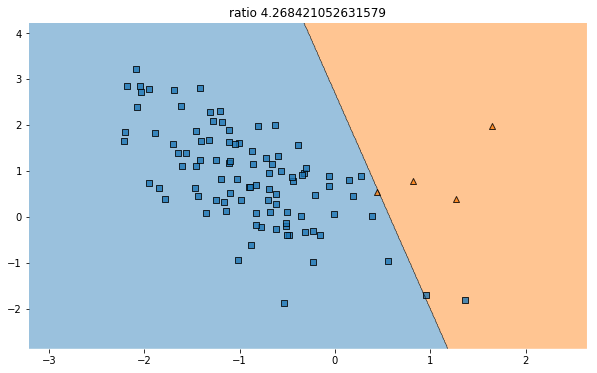

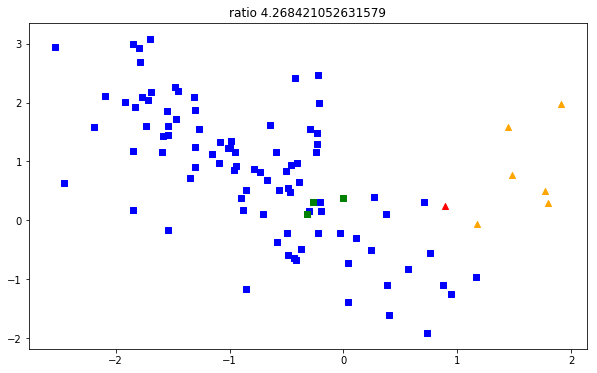

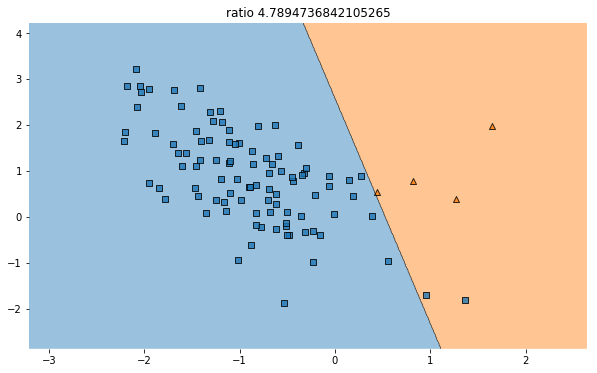

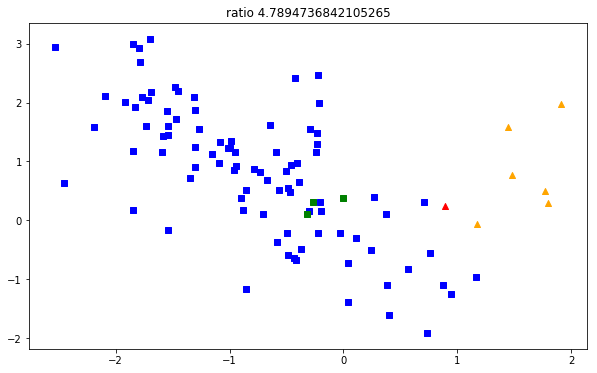

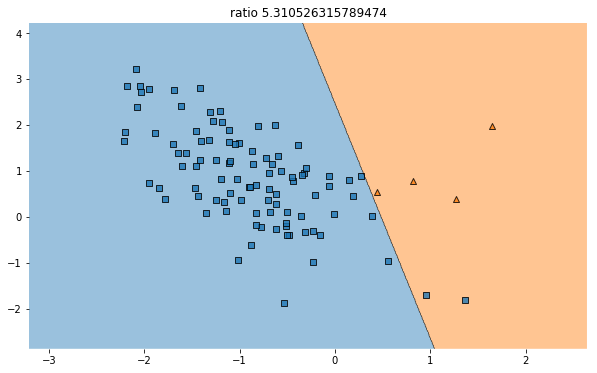

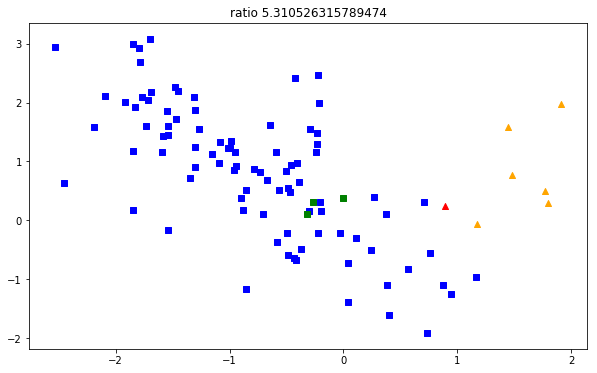

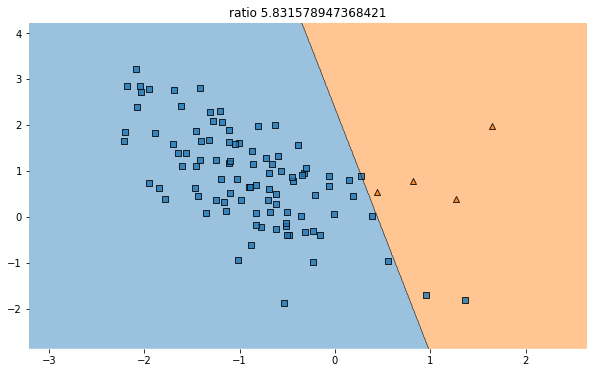

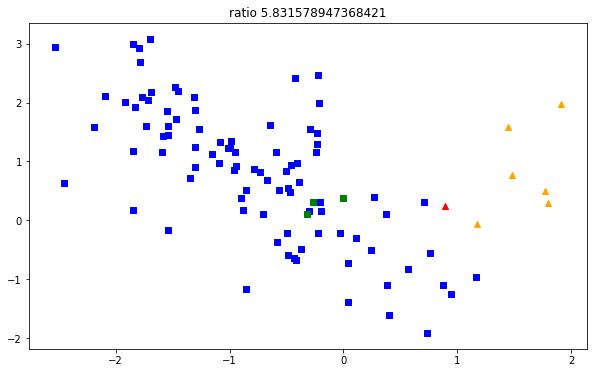

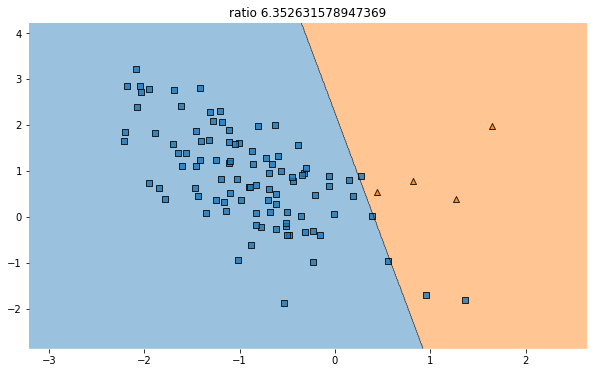

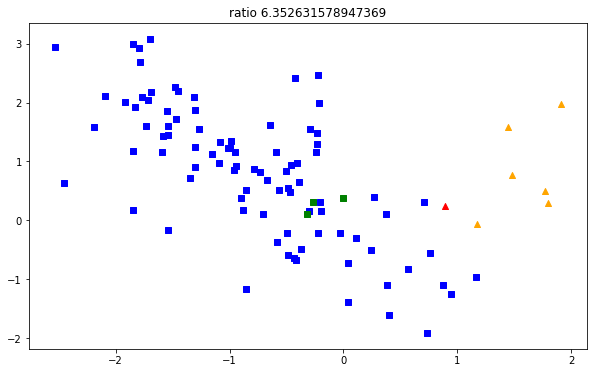

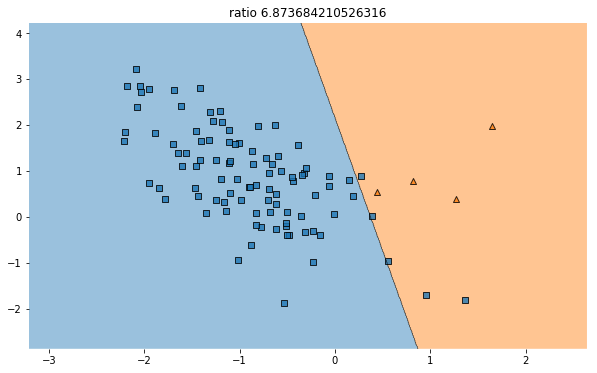

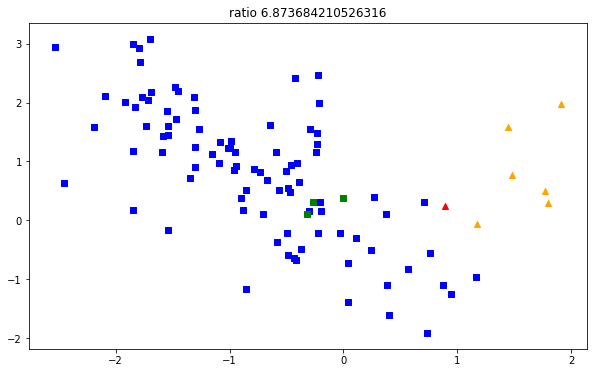

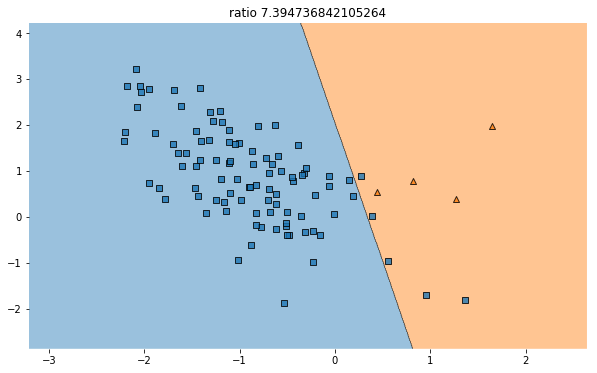

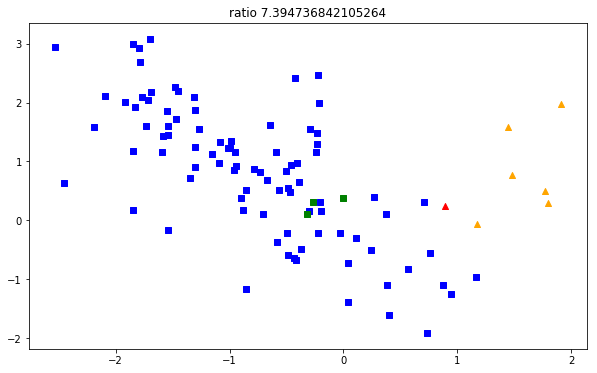

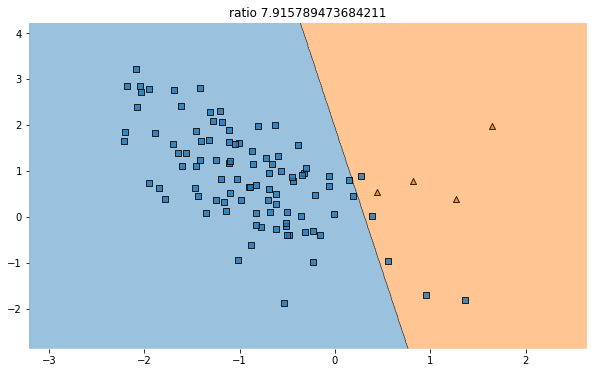

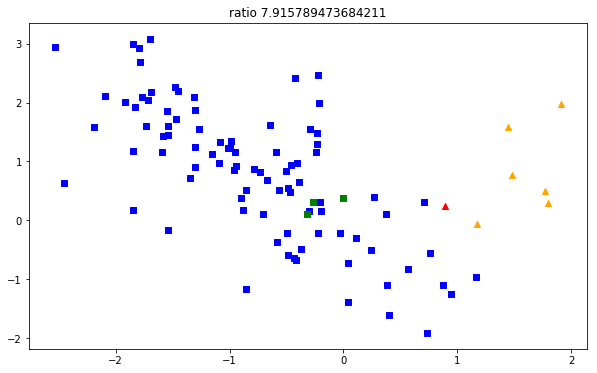

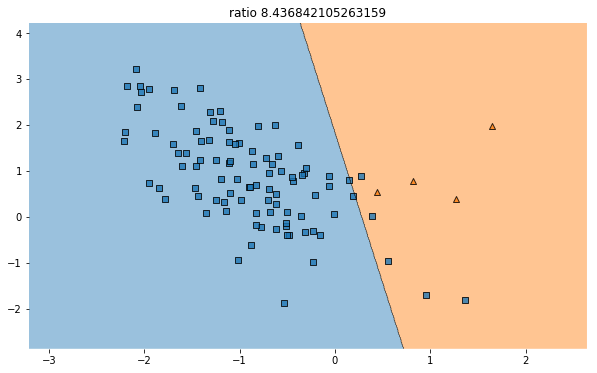

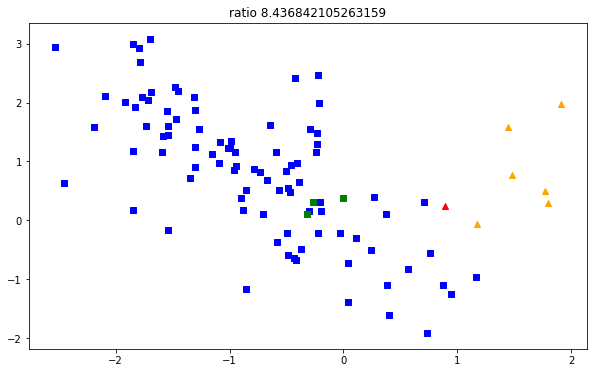

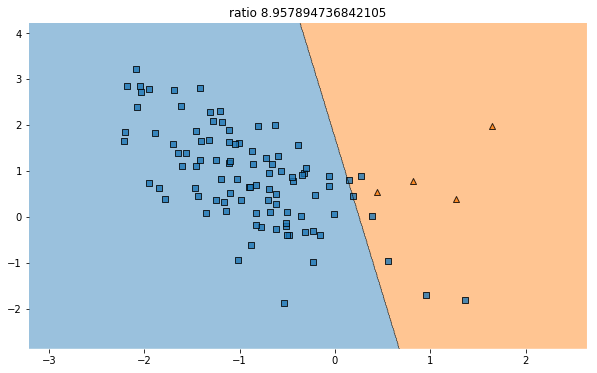

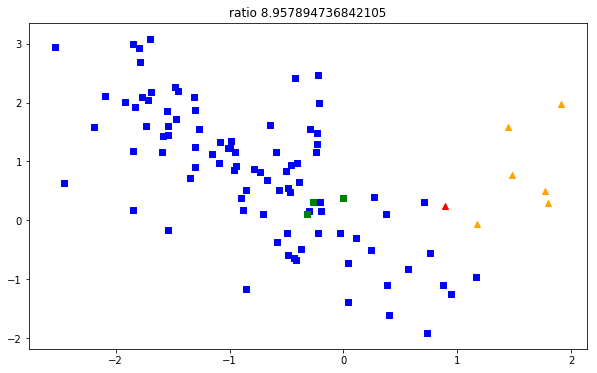

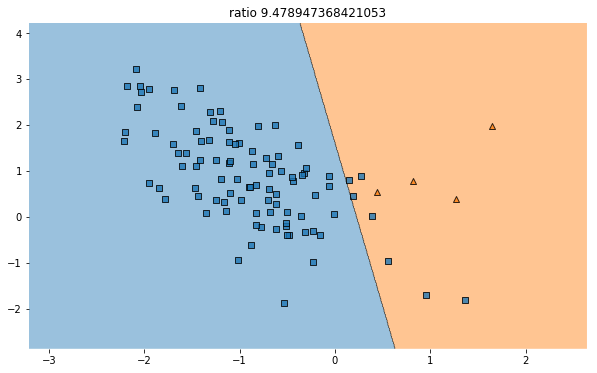

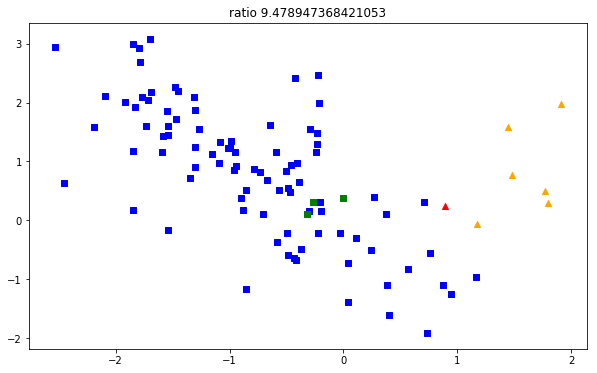

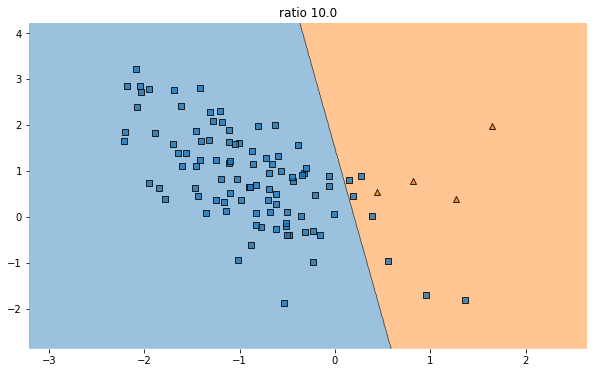

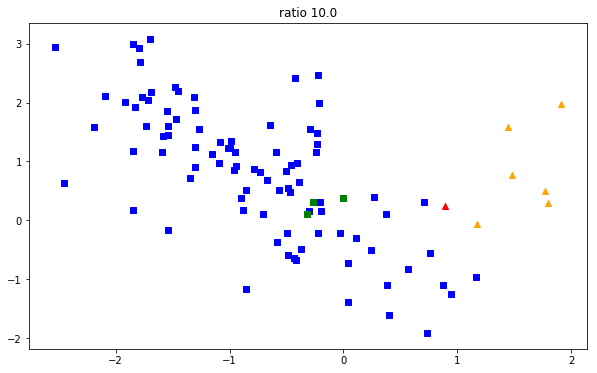

In [16]:
c = compare_linear_xgboost()
c.run()